<a href="https://colab.research.google.com/github/sujithbm/variational-autoencoders/blob/main/vae_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prerequisites
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
from tensorflow import keras
# from keras.datasets import mnist
# from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
# from keras import objectives
from scipy.stats import norm
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/deep_learning_vae/images_final'
test_dir = "/content/drive/MyDrive/deep_learning_vae/images_final_2"
folders = glob.glob("/content/drive/MyDrive/deep_learning_vae/images_final/*")

In [ ]:
EPOCHS = 100
batch_size = 16
z_dim = 10
input_image_size = (48, 48, 3)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  #  rotation_range=10, # rotation
                                  #  width_shift_range=0.2, # horizontal shift
                                  #  height_shift_range=0.2, # vertical shift
                                  #  zoom_range=0.2, # zoom
                                   horizontal_flip=True, # horizontal flip
                                  #  brightness_range=[0.2,1.2], # brightness
                                   validation_split = 0.2)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 4829 images belonging to 2 classes.
Found 1207 images belonging to 2 classes.


In [ ]:
for i in train_generator:
  print(i)
  print(type(i[0]))
  input_image_size = i[0].shape
  for j in i:
    print(j.shape)
  break
# default batch size is 32 images
# the iterator(train_generator) will have (total_images/32) batches
# and each of that will have 2 elements: (32, 48, 48, 3), (32, 2) -> image matrices of 32 images and the tag array for those 32 images
# (32, 2) because we only have 2 classes so it'll either be [1, 0] or [0, 1]

In [ ]:
# should build a functional model and not a sequential model
# coz the mu and logvar separates and joins
# branching of layers is not allowed in sequential model

def build_encoder(model):  
  model = Conv2D(16, kernel_size=3, activation="relu", padding="same", name="conv2d_16_e") (model)
  model = MaxPooling2D((2, 2), name="maxpool2d_1") (model)
  model = Conv2D(32, kernel_size=3, activation="relu", padding="same", name="conv2d_32_e") (model)
  model = MaxPooling2D((2, 2), name="maxpool2d_2") (model)
  model = Conv2D(64, kernel_size=3, activation="relu", padding="same", name="conv2d_64_e") (model)
  model = MaxPooling2D((2, 2), name="maxpool2d_3") (model)
  model = Conv2D(128, kernel_size=3, activation="relu", padding="same", name="conv2d_128_e") (model)
  model = Flatten() (model)
  return model

class my_models(keras.Model):
  def __init__(self, model_framework):
    super(my_models, self).__init__()
    self.model_framework = model_framework    

  def sampling(self, z_dim):
    model = Dense(z_dim, name="dense")(self.model_framework)
    mu = Dense(z_dim, name="mu_dense")(model)
    log_var = Dense(z_dim, name="log_var_dense")(model)
    eps = tf.random.normal(shape=[tf.shape(log_var)[0], tf.shape(log_var)[1]], mean=0., stddev=1.0) # normal distribution of 100 vectors (batch size), vector length -> (2)
    model_z = mu + tf.math.exp(log_var) * eps
    return model_z, mu, log_var

def build_decoder(model):
  model = Dense(6*6*128, activation='relu', name="decoder_dense") (model)
  model = Reshape((6, 6, 128)) (model)
  model = Conv2D(128, kernel_size=3, activation="relu", padding="same", name="conv2d_128_d") (model)
  model = UpSampling2D((2, 2), name="upsample2d_1") (model)
  model = Conv2D(64, kernel_size=3, activation="relu", padding="same", name="conv2d_64_d") (model)
  model = UpSampling2D((2, 2), name="upsample2d_2") (model)
  model = Conv2D(32, kernel_size=3, activation="relu", padding="same", name="conv2d_32_d") (model)
  model = UpSampling2D((2, 2), name="upsample2d_3") (model)
  model = Conv2D(16, kernel_size=3, activation="relu", padding="same", name="conv2d_16_d") (model)
  model = Conv2D(3, kernel_size=3, activation="relu", padding="same", name="conv2d_3_decoder_out") (model)
  return model

In [ ]:


encoder_input = keras.Input(shape=input_image_size, name="Encoder_input_layer")
encoder_layers = build_encoder(encoder_input)
mu_log_var_model = my_models(encoder_layers)
z, mu, log_var = mu_log_var_model.sampling(z_dim)
encoder_model = Model(encoder_input, z, name = "Encoder_Model")

decoder_input = keras.Input(shape = (z_dim,), name = "Decoder_input_layer")
decoder_layers = build_decoder(decoder_input)
decoder_model = Model(decoder_input, decoder_layers, name = "Decoder_Model")

decoder_output = decoder_model(z)

vae = Model(inputs = encoder_input, outputs = decoder_output, name="VAE_MODEL") # this is of type functional
vae.summary()

# print(f'mu shape {mu.shape}, mu o/p is of type tensor {type(mu)}')
# print(f'log_var shape {log_var.shape}, log_var o/p is of type tensor {type(log_var)}')
print(f'encoder input shape: {encoder_input.shape}, type: {type(encoder_input)}')
print(f'encoder output shape: {z.shape}, type: {type(z)}')
print(f'decoder input shape: {decoder_input.shape}, type: {type(decoder_input)}')
print(f'decoder_output shape: {decoder_output.shape}, type: {type(decoder_output)}')
print(f'complete model type {type(vae)}')
# print(f'model output shape {vae.shape}') # throws an error bc it is of type functional model, so it has no shape

Model: "VAE_MODEL"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input_layer (InputLayer [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16_e (Conv2D)            (None, 48, 48, 16)   448         Encoder_input_layer[0][0]        
__________________________________________________________________________________________________
maxpool2d_1 (MaxPooling2D)      (None, 24, 24, 16)   0           conv2d_16_e[0][0]                
__________________________________________________________________________________________________
conv2d_32_e (Conv2D)            (None, 24, 24, 32)   4640        maxpool2d_1[0][0]                
__________________________________________________________________________________________

In [ ]:
# loss
def cal_loss(encoder_input, model_output, mu, log_var):
  encoder_input = Flatten() (encoder_input)
  model_output = Flatten() (model_output)
  reconstruction_loss = keras.losses.binary_crossentropy(encoder_input, model_output)
  kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
  vae_loss = reconstruction_loss + kl_loss
  return vae_loss

In [ ]:
# add loss
vae.summary()
vae.add_loss(cal_loss(encoder_input, decoder_output, mu, log_var))
opt = keras.optimizers.Adam(1.5e-4, 0.5)
vae.compile(optimizer=opt)


Model: "VAE_MODEL"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input_layer (InputLayer [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16_e (Conv2D)            (None, 48, 48, 16)   448         Encoder_input_layer[0][0]        
__________________________________________________________________________________________________
maxpool2d_1 (MaxPooling2D)      (None, 24, 24, 16)   0           conv2d_16_e[0][0]                
__________________________________________________________________________________________________
conv2d_32_e (Conv2D)            (None, 24, 24, 32)   4640        maxpool2d_1[0][0]                
__________________________________________________________________________________________

In [ ]:
# train
vae.fit(train_generator,
       shuffle=True,
       epochs=EPOCHS,
       batch_size=batch_size,
       validation_data=(validation_generator, None), verbose=1)

Epoch 1/100
302/302 [==============================] - 16s 47ms/step - loss: 0.8010 - val_loss: 0.7085
Epoch 2/100
302/302 [==============================] - 14s 45ms/step - loss: 0.7023 - val_loss: 0.6945
Epoch 3/100
302/302 [==============================] - 14s 45ms/step - loss: 0.6939 - val_loss: 0.6958
Epoch 4/100
302/302 [==============================] - 14s 46ms/step - loss: 0.6910 - val_loss: 0.6905
Epoch 5/100
302/302 [==============================] - 14s 45ms/step - loss: 0.6896 - val_loss: 0.6875
Epoch 6/100
302/302 [==============================] - 13s 44ms/step - loss: 0.6896 - val_loss: 0.6875
Epoch 7/100
302/302 [==============================] - 14s 45ms/step - loss: 0.6890 - val_loss: 0.6903
Epoch 8/100
302/302 [==============================] - 13s 44ms/step - loss: 0.6882 - val_loss: 0.6872
Epoch 9/100
302/302 [==============================] - 14s 45ms/step - loss: 0.6882 - val_loss: 0.6865
Epoch 10/100
302/302 [==============================] - 14s 45ms/step - l

In [ ]:
encoder_model.summary()

In [ ]:
# Plot of the digit classes in the latent space
train_latent = encoder_model.predict(train_generator, batch_size=batch_size)
# plt.figure(figsize=(6, 6))
# plt.scatter(train_latent[:, 0], train_latent[:, 1], c=y_te)
# plt.colorbar()
# plt.show()

In [ ]:
train_latent[0].reshape(1, 10)

array([[ 1.7469707 , -0.7932518 ,  1.1546078 ,  0.5412152 ,  1.1460966 ,
        -0.14772281,  0.9331553 ,  0.47638413,  0.5478683 ,  1.8570855 ]],
      dtype=float32)

In [ ]:
latent_flattened = train_latent.flatten()
print(max(latent_flattened), min(latent_flattened))

4.2463646 -4.02951


In [ ]:
decoder_model.summary()

In [ ]:
test_latent = np.random.uniform(low=-5, high=5, size=(1,10))
test_latent

array([[-1.68198408, -4.32069075, -0.32728794, -2.89471062,  0.50505821,
         4.66270116,  4.02605048, -4.35463215,  0.63264676, -1.22480963]])

In [ ]:
# recon_image = decoder_model.predict(train_latent[0].reshape(1, 10))
recon_image = decoder_model.predict(test_latent)
# recon_image

In [ ]:
recon_image.shape

(1, 48, 48, 3)

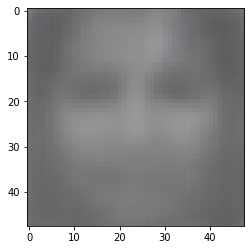

In [ ]:
recon_resize = recon_image * 255
plt.imshow(np.uint8(recon_resize[0]))

In [ ]:
decoder_model.save("/content/drive/MyDrive/deep_learning_vae/decoder_model_1.h5")

In [ ]:
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_te.shape

(10000, 28, 28)

In [ ]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 100, 100
n_hidden, z_dim = 256, 2

(60000, 784) (10000, 784)


In [ ]:
x_tr.shape[1:]

(784,)

In [ ]:
# encoder
print("Input-> input: ", x_tr.shape[1:])
x = Input(shape=(x_tr.shape[1:]))
print("Dense1-> input: {} output: {}".format(x.shape, n_hidden))
x_encoded = Dense(n_hidden, activation='relu')(x)
print("Dense2-> input: {} output: {}".format(x_encoded.shape, n_hidden//2))
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
print("mu-> input: {} output: {}".format(x_encoded.shape, z_dim))
mu = Dense(z_dim)(x_encoded)
print("log_var-> input: {} output: {}".format(x_encoded.shape, z_dim))
log_var = Dense(z_dim)(x_encoded)

Input-> input:  (784,)
Dense1-> input: (None, 784) output: 256
Dense2-> input: (None, 256) output: 128
mu-> input: (None, 128) output: 2
log_var-> input: (None, 128) output: 2


In [ ]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0) # normal distribution of 100 vectors (batch size), vector length -> (2)
    return mu + K.exp(log_var) * eps

# mu and log_var has output shape of 2 
z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var]) # sends [mu, log_var] as input to sampling and it returns mu + exp(log_var) * eps
                                                           # lambda is just making a function as another layer

In [ ]:
z.shape

TensorShape([100, 2])

In [ ]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [ ]:
# loss
reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Epoch 1/100
600/600 [==============================] - 6s 3ms/step - loss: 210.4884 - val_loss: 167.0228
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 165.5876 - val_loss: 159.6682
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 157.6925 - val_loss: 154.4682
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 153.0843 - val_loss: 152.2588
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 150.2304 - val_loss: 149.4568
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 148.3287 - val_loss: 147.0984
Epoch 7/100
600/600 [==============================] - 2s 3ms/step - loss: 146.2178 - val_loss: 146.2206
Epoch 8/100
600/600 [==============================] - 2s 3ms/step - loss: 145.2104 - val_loss: 145.3013
Epoch 9/100
600/600 [==============================] - 2s 3ms/step - loss: 144.1874 - val_loss: 145.2931
Epoch 10/100
600/600 [==============================] -

In [ ]:
# build encoder
encoder = Model(x, mu)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


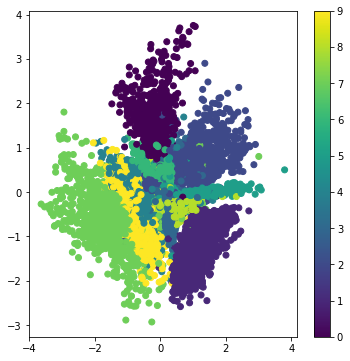

In [ ]:
# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In [ ]:
for i in range(10):
  print(x_te_latent[i], y_te[i])

[-0.49585247  2.4054952 ] 7
[ 0.14019606 -0.21775177] 2
[-2.1255994   0.19796899] 1
[ 0.53307086 -1.1992298 ] 0
[0.38128975 0.37693903] 4
[-1.8070657   0.16999751] 1
[0.00885977 0.39180586] 4
[0.7254273 0.2915061] 9
[-0.5333157 -0.6943913] 5
[-0.06514704  0.9823889 ] 9


In [ ]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              multiple                  384       
_________________________________________________________________
dense_5 (Dense)              multiple                  33024     
_________________________________________________________________
dense_6 (Dense)              multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


[[-1.64485363 -1.64485363]]
[[-1.20404696 -1.64485363]]
[[-0.92082298 -1.64485363]]
[[-0.69714143 -1.64485363]]
[[-0.50396537 -1.64485363]]
[[-0.32807211 -1.64485363]]
[[-0.16184417 -1.64485363]]
[[-1.39145821e-16 -1.64485363e+00]]
[[ 0.16184417 -1.64485363]]
[[ 0.32807211 -1.64485363]]
[[ 0.50396537 -1.64485363]]
[[ 0.69714143 -1.64485363]]
[[ 0.92082298 -1.64485363]]
[[ 1.20404696 -1.64485363]]
[[ 1.64485363 -1.64485363]]
[[-1.64485363 -1.20404696]]
[[-1.20404696 -1.20404696]]
[[-0.92082298 -1.20404696]]
[[-0.69714143 -1.20404696]]
[[-0.50396537 -1.20404696]]
[[-0.32807211 -1.20404696]]
[[-0.16184417 -1.20404696]]
[[-1.39145821e-16 -1.20404696e+00]]
[[ 0.16184417 -1.20404696]]
[[ 0.32807211 -1.20404696]]
[[ 0.50396537 -1.20404696]]
[[ 0.69714143 -1.20404696]]
[[ 0.92082298 -1.20404696]]
[[ 1.20404696 -1.20404696]]
[[ 1.64485363 -1.20404696]]
[[-1.64485363 -0.92082298]]
[[-1.20404696 -0.92082298]]
[[-0.92082298 -0.92082298]]
[[-0.69714143 -0.92082298]]
[[-0.50396537 -0.92082298]]
[[-0

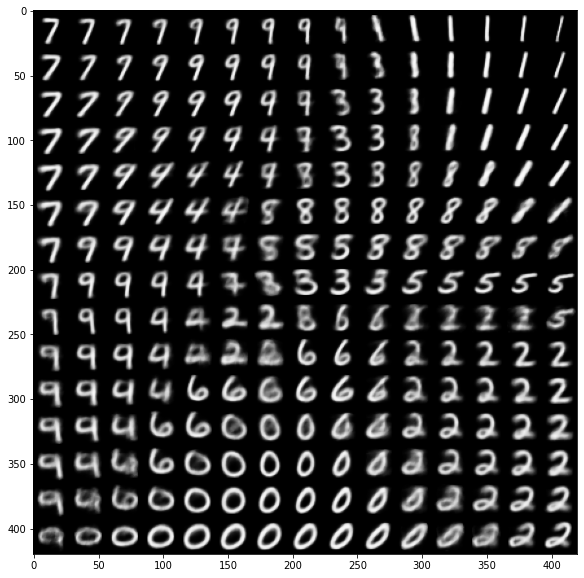

In [ ]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        print(z_sample)
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
"A comprehensive database for benchmarking imaging systems." IEEE Transactions on Pattern Analysis and Machine Intelligence (2018).